## Forward Model Using Separable DeepONet

In [6]:
import os

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, random_split
from torch import nn
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning import seed_everything
from pathlib import Path
from sklearn.model_selection import train_test_split
torch.set_float32_matmul_precision('high') # or'high'. This is to properly utilize Tensor Cores of my CUDA device ('NVIDIA RTX A6000')

seed_everything(42, workers=True)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

Seed set to 42


cuda


In [ ]:
class config:
    def __init__(self):
        #The File paths
        self.train_path = 'C:/Users/idris_oduola/Documents/Projects/FWI/dataset/train_samples'
        self.test_path = 'C:/Users/idris_oduola/Documents/Projects/FWI/dataset/test'
        #self.test_num = sum(1 for f in folder.iterdir() if f.is_file())
        #print(f'The number of files in test data is: {self.test_num}') 
        #self.submission_path = 'C:/Users/idris_oduola/Documents/Projects/FWI/sample_submission.csv'
        self.model_path = 'C:/Users/idris_oduola/Documents/Projects/FWI/dataset/fwi_model.pt'
        self.checkpoint_dir = 'C:/Users/idris_oduola/Documents/Projects/FWI/dataset/checkpoint_fwi'
        self.dset1 = ["FlatVel_A","FlatVel_B", "Style_A", "Style_B","CurveVel_A","CurveVel_B"] #Dataset storage names used for training
        self.dset2 = ["FlatFault_A", "FlatFault_B", "CurveFault_A", "CurveFault_B"]

        #Trunk Net parameter
        self.base_channel = 32
        self.hidden_dim = 128
        self.layers = 10
        
        #Branch Net Parameter
        self.n_unets = 2
        self.out = 50
        #Optimizer
        self.lr = 0.0006
        self.weight_decay = 1e-4 #Regularization weight
        
        #The training parameters
        self.num_epoch = 100
        self.batch_size = 20

        #Learning rate scheduler
        self.step_size = 20  #To decay after every, say 10 epochs
        self.gamma = 0.5      #To reduce the learning rate by gamma (say, 1/2)

        

cfg = config()

### 1.1 Preparing the Data

In [ ]:

def prepare_data(cfg):
    #First we extract the velocity and seismic data's for training and testing
    vel_data = []; seismic_data = [] #; test_data = []

    #Extracting and concatenating the training data
    for domain in cfg.dset1: 
        model_path = Path(cfg.train_path) / domain / "model"
        data_path = Path(cfg.train_path) / domain / "data"
    
        # Load all .npy files in this domain and extend the master lists
        vel_data += [np.load(str(f)) for f in sorted(model_path.glob("*.npy"))]
        seismic_data += [np.load(str(f)) for f in sorted(data_path.glob("*.npy"))]
    
    for domain in cfg.dset2: 
        model_path = Path(cfg.train_path) / domain 
        data_path = Path(cfg.train_path) / domain
    
        # Load all .npy files in this domain and extend the master lists
        vel_data += [np.load(str(f)) for f in sorted(model_path.glob("vel*.npy"))]
        seismic_data += [np.load(str(f)) for f in sorted(data_path.glob("seis*.npy"))]

    
    # Concatenate all at once
    sample_points = sum(v.shape[0] for v in vel_data) #To ensure we have the required number of data
    vel_data = np.concatenate(vel_data, axis=0)
    #vel_data = (vel_data - vel_data.mean())/(vel_data.std() + 1e-8)
    seismic_data = np.concatenate(seismic_data, axis=0)
    assert ( vel_data.shape[0] == sample_points and seismic_data.shape[0] == sample_points
           ), f"Expected sample size {sample_points} but got {vel_data.shape[0]} and {seismic_data.shape[0]}"
    print(f"Total data --> Seismic: {seismic_data.shape}, Velocity: {vel_data.shape}")

    #Next we split the downsampled dataset into training, testing and validation
    dataset = TensorDataset(torch.from_numpy(vel_data).float(), torch.from_numpy(seismic_data).float())

    branch_train_set, val_set, test_set = random_split(dataset, [sample_points - 200, 100, 100])

    print(f"After Split, Train samples: {len(branch_train_set)}, test samples: {len(test_set)}, validation_samples: {len(test_set)}")
    

    #DataLoader
    train_loader = DataLoader(branch_train_set, batch_size = cfg.batch_size, shuffle = True)
    val_loader = DataLoader(val_set, batch_size = cfg.batch_size, shuffle = False)
    test_loader = DataLoader(test_set, batch_size = cfg.batch_size, shuffle = False)

    return train_loader, val_loader, test_loader 


In [13]:
class DataModule(pl.LightningDataModule):
    def __init__(self,cfg):
        super().__init__()
        self.cfg = cfg
        self.train_loader = None
        self.val_loader = None
        self.test_loader = None

    def setup(self, stage = None):
        self.train_loader, self.val_loader, self.test_loader= prepare_data(self.cfg)
        print('DataLoaded Successfully!!')

    def train_dataloader(self):
        return self.train_loader

    def val_dataloader(self):
        return self.val_loader

    def test_dataloader(self):
        return self.test_loader
    
    def predict_dataloader(self):
        return self.test_loader

data_module = DataModule(cfg)
data_module.setup()

Total data --> Seismic: (10000, 5, 1000, 70), Velocity: (10000, 1, 70, 70)
After Split, Train samples: 9800, test samples: 100, validation_samples: 100
DataLoaded Successfully!!


### Visualizing the dataset

In [18]:
batch = next(iter(data_module.predict_dataloader()))
vel, seis = batch
print("Velocity batch shape:", vel.shape)
print("Seismic batch shape:", seis.shape)


Velocity batch shape: torch.Size([50, 1, 70, 70])
Seismic batch shape: torch.Size([50, 5, 1000, 70])


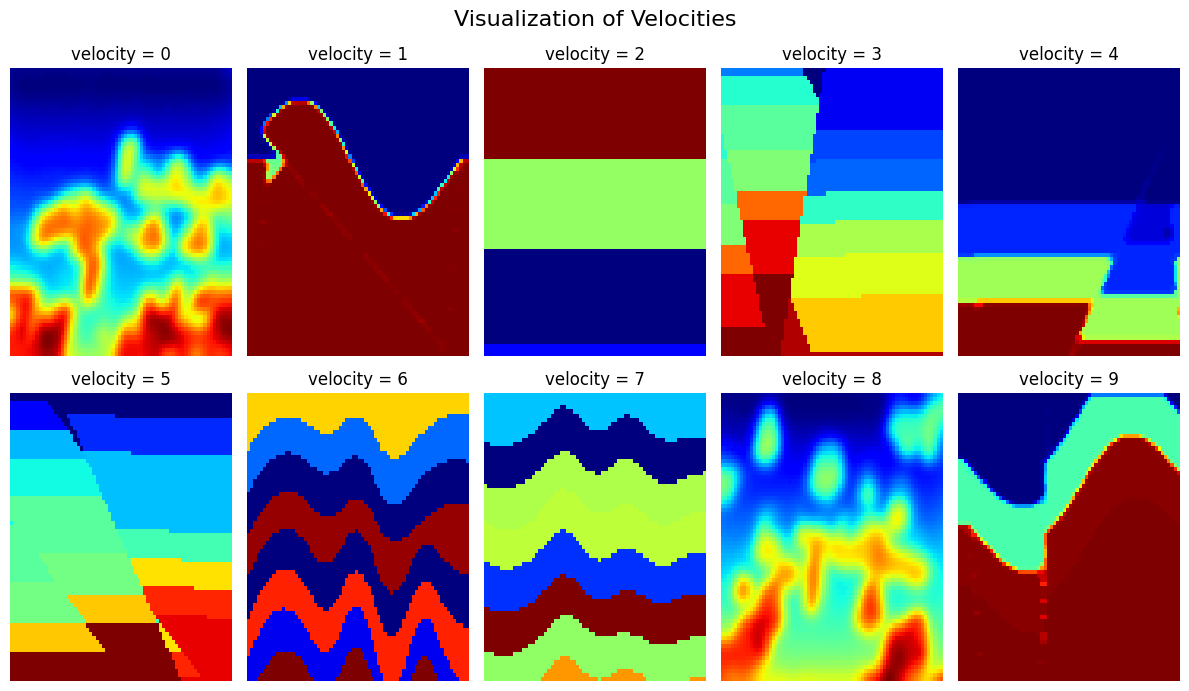

In [27]:
plt.figure(figsize = (12,7))
plt.suptitle("Visualization of Velocities", fontsize=16)
vel_new = vel.squeeze(1)
for i in range(10):
    plt.subplot(2,5,i+1)
    plt.title(f"velocity = {i}")
    plt.imshow(vel_new[i], cmap='jet', extent=[0, 70, 70, 0], aspect='auto')
    plt.axis("off")
plt.tight_layout()
plt.show()

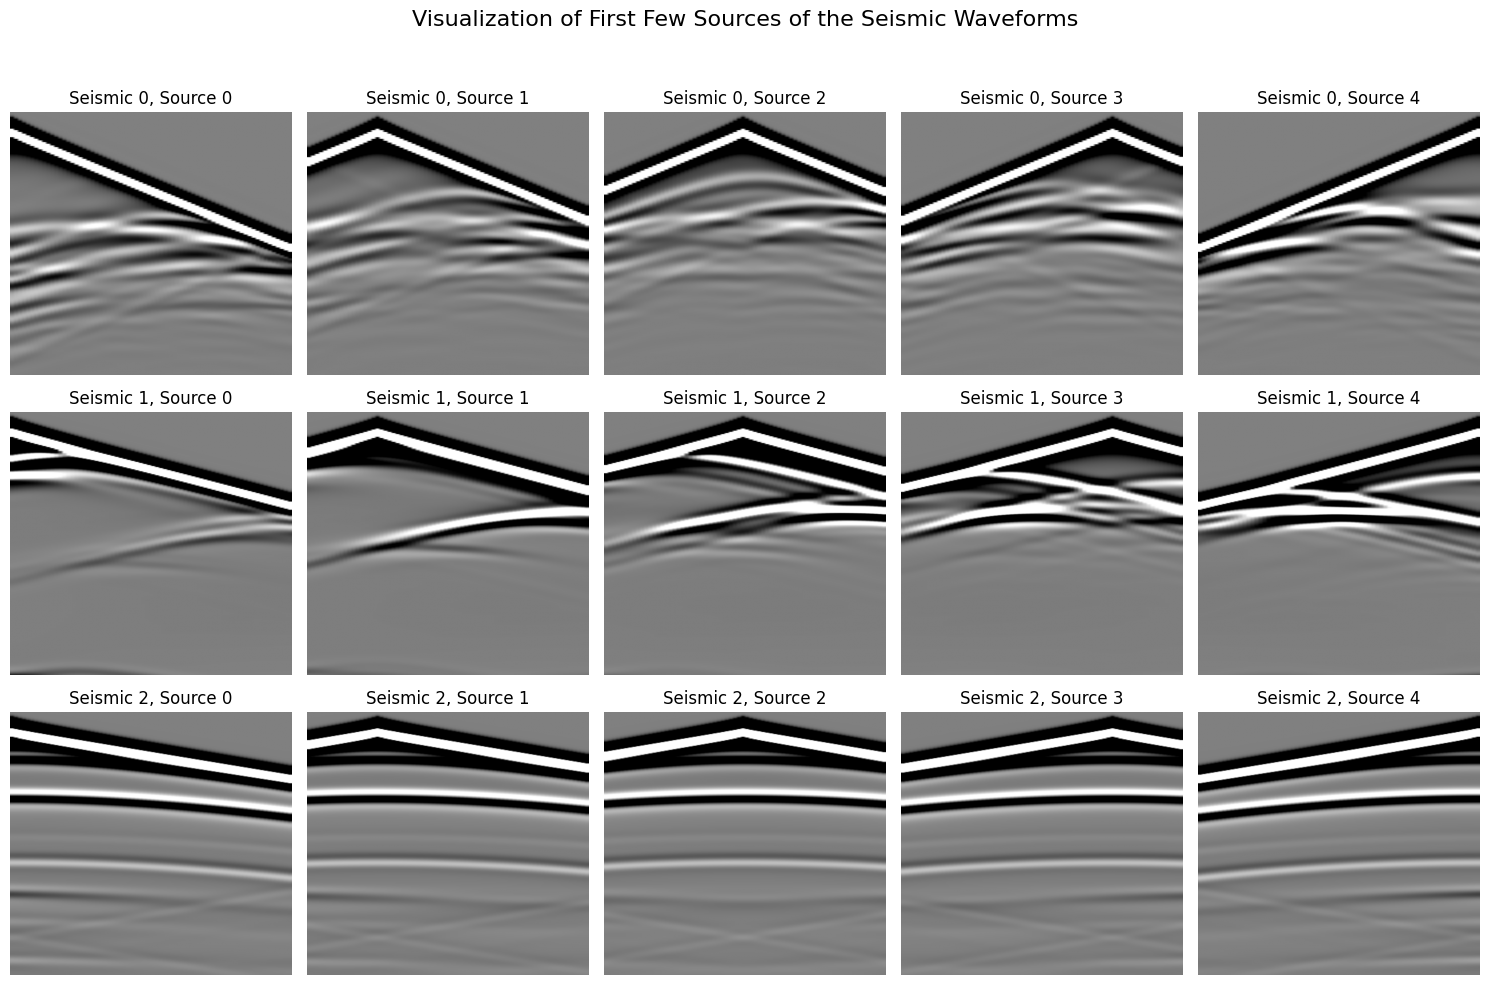

In [38]:
plt.figure(figsize=(15, 10))  # Adjust width for 5 columns
plt.suptitle("Visualization of First Few Sources of the Seismic Waveforms", fontsize=16)

num_samples = 3
num_sources = 5

for i in range(num_samples):       # Rows: each seismic sample
    for j in range(num_sources):   # Columns: each source
        plt.subplot(num_samples, num_sources, num_sources * i + j + 1)
        plt.imshow(seis[i, j, :, :], extent=[0, 70, 1000, 0], aspect='auto', cmap='gray', vmin=-0.5, vmax=0.5)
        plt.title(f"Seismic {i}, Source {j}")
        plt.axis("off")

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


## Building the Seismic Separable U-DeepONet

### The UNet